<h1>Words Size Regression - Modèle LeNet</h1>
<br>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!mkdir database
! mkdir database/ascii
! tar xzf drive/MyDrive/ocr/database/ascii.tgz -C database/ascii

! mkdir database/words
! tar xzf drive/MyDrive/ocr/database/words.tgz -C database/words

! mkdir database/images_test
! cp -r drive/MyDrive/ocr/database/images_test/* database/images_test/

! cp drive/MyDrive/ocr/src/streamlit/importation.py importation.py
! cp drive/MyDrive/ocr/src/streamlit/preprocessor_2.py preprocessor_2.py
! cp drive/MyDrive/ocr/src/streamlit/wsmodel.py wsmodel.py

! mkdir models
! cp drive/MyDrive/ocr/models/* models/

In [1]:
from importation import Importation

from preprocessor import Preprocess
import wsmodel
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

# Importation des données - preprocessing

In [14]:
imp = Importation('database')
df = imp.get_words().sample(frac=1, random_state=1).reset_index()
# n_lettres_max=11
# df = df[df.word_size<=n_lettres_max][['file', 'word_size', 'label']]
df.word_size = df.word_size.astype('float32')
print("Nombre d'enregistrements ", df.shape[0])


df = df[['file', 'word_size', 'label']]
df.info()
image_width = 128
image_height = 32
batch_size = 64
img_size = (image_width, image_height)
prepro = Preprocess(img_size, batch_size=batch_size, gaussianBlur=True)

df_train, df_valid, df_test = prepro.split_data(df, train_size=0.9)

x_train, y_train = df_train["file"].values, df_train["word_size"].values
x_test, y_test = df_test["file"].values, df_test["word_size"].values
x_valid, y_valid = df_valid["file"].values, df_valid["word_size"].values

train_ds = prepro.prepare_dataset_word_size(x_train, y_train)
validation_ds = prepro.prepare_dataset_word_size(x_valid, y_valid)
test_ds = prepro.prepare_dataset_word_size(x_test, y_test)



Nombre d'enregistrements  96454
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96454 entries, 0 to 96453
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file       96454 non-null  object 
 1   word_size  96454 non-null  float32
 2   label      96454 non-null  object 
dtypes: float32(1), object(2)
memory usage: 1.8+ MB
initialisation


# Chargement du modèle

In [3]:
#import importlib
#import sys
#importlib.reload(sys.modules['wsmodel']) 


train = False
model = wsmodel.create_model_lenet(image_width, image_height)
#model = wsmodel.create_model_cnn(image_width, image_height)
#model = wsmodel.create_model_dense(image_width, image_height)
if train:
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 124, 28, 30)       780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 14, 30)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 14, 30)        0         
                                                                 
 conv2 (Conv2D)              (None, 60, 12, 50)        13550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 6, 50)        0         
 2D)                                                         

# Entraînement du modèle 

Epoch 1/50


2022-09-19 08:57:05.059232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


1357/1357 [==============================] - 293s 215ms/step - loss: 2.4987 - mean_absolute_error: 1.0443 - val_loss: 5.6641 - val_mean_absolute_error: 1.9145
Epoch 2/50
1357/1357 [==============================] - 9s 7ms/step - loss: 1.0838 - mean_absolute_error: 0.7429 - val_loss: 4.1876 - val_mean_absolute_error: 1.6170
Epoch 3/50
1357/1357 [==============================] - 9s 7ms/step - loss: 0.8554 - mean_absolute_error: 0.6534 - val_loss: 2.8019 - val_mean_absolute_error: 1.3157
Epoch 4/50
1357/1357 [==============================] - 9s 7ms/step - loss: 0.7624 - mean_absolute_error: 0.6131 - val_loss: 2.0746 - val_mean_absolute_error: 1.1135
Epoch 5/50
1357/1357 [==============================] - 9s 7ms/step - loss: 0.7040 - mean_absolute_error: 0.5871 - val_loss: 1.2282 - val_mean_absolute_error: 0.8146
Epoch 6/50
1357/1357 [==============================] - 9s 7ms/step - loss: 0.6591 - mean_absolute_error: 0.5670 - val_loss: 0.9649 - val_mean_absolute_error: 0.7080
Epoch 7/50


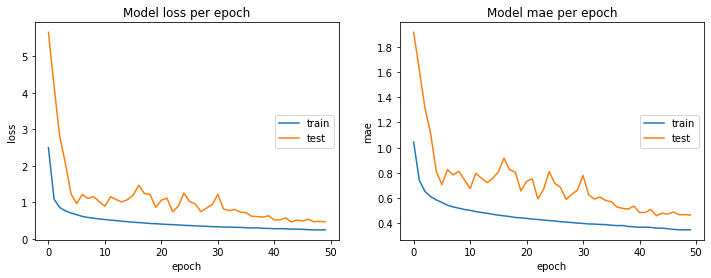

In [4]:
if train:
    epochs = 50
    training_history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        verbose=1
    )

    train_loss = training_history.history["loss"]
    val_loss = training_history.history["val_loss"]
    train_acc = training_history.history["mean_absolute_error"]
    val_acc = training_history.history["val_mean_absolute_error"]
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Model loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')

    plt.subplot(122)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Model mae per epoch')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')
    model.save_weights("models/word_size_lenet.h1")

else: 
    model.load_weights("models/word_size_lenet.h1")

# Prédictions

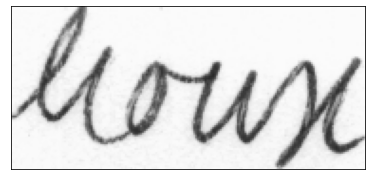

Label     : house
Word size     : 5
Prédiction:  4.3


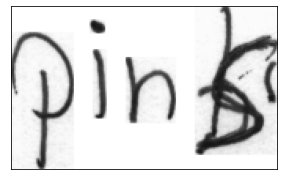

Label     : pins
Word size     : 4
Prédiction:  4.78


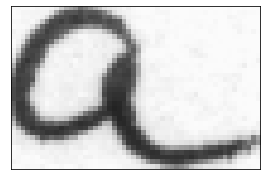

Label     : a
Word size     : 1
Prédiction:  1.14


In [7]:


# Création d'un dataset pour une image unique
def get_ds(img_path, word_size):
    x = np.array([img_path])
    y = np.array([word_size])
    ds = prepro.prepare_dataset_word_size(x, y)
    return ds

def get_prediction(ds):
    errors = []
    output_word_size = []
    for batch in ds:
        word_size = batch[1] 
        batch_images = batch[0]
        #batch_images = tf.transpose(batch[0], [0,2,1,3])
        preds = model.predict(batch_images, verbose=0)
        output_word_size += [v[0] for v in preds.tolist()]
    return output_word_size


files = []
labels = []
predictions = []
distances = []
df_predict = df_test
for i in np.random.choice(np.arange(0, len(df_predict)), size=3):  
  label = df_predict.iloc[i].label
  word_size = df_predict.iloc[i].word_size
  img_path = df_predict.iloc[i].file
  ds = get_ds(img_path, word_size)
  prediction= get_prediction(ds)
  prediction = np.round(prediction,2)[0]
  image = cv2.imread(img_path)
  plt.figure(figsize=(10,3))
  plt.imshow(image, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print(f"Label     : {label}")
  print(f"Word size     : {int(word_size)}")
  print("Prédiction: ",prediction)


## Prédiction sur l'ensemble de test

In [8]:
ds = test_ds
output = get_prediction(ds)

        
df_result = pd.DataFrame({'file' : df_test.file,
                          'label': df_test.label,
                          'word_size' : df_test.word_size,
                          'prediction' : output,
                         })

df_result['error'] = np.round(np.abs((df_result['word_size'] -  df_result['prediction'])),2)

print(f"Erreur Moyenne : {df_result.error.mean()}")
print(df_result.error.describe())
df_result.drop("file", axis=1).head(20)

Erreur Moyenne : 0.46039809247356417
count    4823.000000
mean        0.460398
std         0.491846
min         0.000000
25%         0.130000
50%         0.290000
75%         0.620000
max         4.950000
Name: error, dtype: float64


,label,word_size,prediction,error
91631,swift,5.0,4.139264,0.86
91632,Betti's,7.0,6.496086,0.50
91633,like,4.0,2.743648,1.26
91634,unceasing,9.0,8.732768,0.27
91635,Fell,4.0,4.884888,0.88
91636,Morfydd,7.0,7.342499,0.34
91637,in,2.0,2.143548,0.14
91638,unguarded,9.0,8.111118,0.89
91639,was,3.0,4.197986,1.20
91640,&,1.0,1.047023,0.05
